# Complex NetCDF to Zarr Recipe: TerraClimate 

## About the Dataset

From http://www.climatologylab.org/terraclimate.html:

> TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019. We plan to update these data periodically (annually).

## What makes it tricky

This is an advanced example that illustrates the following concepts
- _Multiple variables in different files_: There is one file per year for a dozen different variables.
- _Complex Preprocessing_: We want to apply different preprocessing depending on the variable. This example shows how.
- _Inconsistent size of data in input files_: This means we have to scan each input file and cache its metadata before we can start writing the target.

This recipe requires a new storage target, a `metadata_cache`. In this example, this is just another directory. You could hypothetically use a database or other key/value store for this.

In [1]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe
from pangeo_forge_recipes.patterns import FilePattern, ConcatDim, MergeDim
import xarray as xr

## Define Filename Pattern 

To keep this example smaller, we just use two years instead of the whole record.

In [2]:
target_chunks = {"lat": 1024, "lon": 1024, "time": 12}
# only do two years to keep the example small; it's still big!
years = list(range(1958, 1960))
variables = [
    "aet",
    "def",
    "pet",
    "ppt",
    "q",
    "soil",
    "srad",
    "swe",
    "tmax",
    "tmin",
    "vap",
    "ws",
    "vpd",
    "PDSI",
]

def make_filename(variable, time):
    return f"http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_{variable}_{time}.nc"

pattern = FilePattern(
    make_filename,
    ConcatDim(name="time", keys=years),
    MergeDim(name="variable", keys=variables)
)
pattern

<FilePattern {'time': 2, 'variable': 14}>

Check out the pattern:

In [3]:
for key, filename in pattern.items():
    break
key, filename

(frozenset({DimIndex(name='time', index=0, sequence_len=2, operation=<CombineOp.CONCAT: 2>),
            DimIndex(name='variable', index=0, sequence_len=14, operation=<CombineOp.MERGE: 1>)}),
 'http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_aet_1958.nc')

## Define Preprocessing Functions

These functions apply masks for each variable to remove invalid data.

In [4]:
rename_vars = {'PDSI': 'pdsi'}

mask_opts = {
    "PDSI": ("lt", 10),
    "aet": ("lt", 32767),
    "def": ("lt", 32767),
    "pet": ("lt", 32767),
    "ppt": ("lt", 32767),
    "ppt_station_influence": None,
    "q": ("lt", 2147483647),
    "soil": ("lt", 32767),
    "srad": ("lt", 32767),
    "swe": ("lt", 10000),
    "tmax": ("lt", 200),
    "tmax_station_influence": None,
    "tmin": ("lt", 200),
    "tmin_station_influence": None,
    "vap": ("lt", 300),
    "vap_station_influence": None,
    "vpd": ("lt", 300),
    "ws": ("lt", 200),
}

def apply_mask(key, da):
    """helper function to mask DataArrays based on a threshold value"""
    if mask_opts.get(key, None):
        op, val = mask_opts[key]
        if op == "lt":
            da = da.where(da < val)
        elif op == "neq":
            da = da.where(da != val)
    return da


def preproc(ds):
    """custom preprocessing function for terraclimate data"""
    
    rename = {}

    station_influence = ds.get("station_influence", None)

    if station_influence is not None:
        ds = ds.drop_vars("station_influence")

    var = list(ds.data_vars)[0]

    if var in rename_vars:
        rename[var] = rename_vars[var]

    if "day" in ds.coords:
        rename["day"] = "time"

    if station_influence is not None:
        ds[f"{var}_station_influence"] = station_influence

    with xr.set_options(keep_attrs=True):
        ds[var] = apply_mask(var, ds[var])

    if rename:
        ds = ds.rename(rename)
                
    return ds


## Define Recipe

We are now ready to define the recipe.
We also specify the desired chunks of the target dataset.

A key property of this recipe is `nitems_per_input=None`, which triggers caching of input metadata.

In [5]:
chunks = {"lat": 1024, "lon": 1024, "time": 12}

recipe = XarrayZarrRecipe(
    file_pattern=pattern,
    target_chunks=target_chunks,
    process_chunk=preproc
)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 2, 'variable': 14}>, storage_config=StorageConfig(target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x179047400>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z'), cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x179047400>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmpquyof0ta/TUgR0g5v'), metadata=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x179047400>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmpquyof0ta/CpxAUJnB')), inputs_per_chunk=1, target_chunks={'lat': 1024, 'lon': 1024, 'time': 12}, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=<function preproc at 0x1790443a0>, lock_timeout=None, subset

## Execute with Prefect

This produces A LOT of output because we turn on logging.

In [6]:
# logging will display some interesting information about our recipe during execution
from pangeo_forge_recipes.recipes import setup_logging

setup_logging()

In [7]:
flow = recipe.to_prefect()
flow.run()

[2022-03-10 11:19:13-0800] INFO - prefect.FlowRunner | Beginning Flow run for 'pangeo-forge-recipe'
[2022-03-10 11:19:13-0800] INFO - prefect.TaskRunner | Task 'cache_input': Starting task run...
[2022-03-10 11:19:13-0800] INFO - prefect.TaskRunner | Task 'cache_input': Finished task run for task with final state: 'Mapped'
[2022-03-10 11:19:13-0800] INFO - prefect.TaskRunner | Task 'cache_input[0]': Starting task run...


[03/10/22 11:19:13] INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=673808;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=679191;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>),                               
                             DimIndex(name='variable', index=0,                              
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=628346;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=477301;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_aet_1958.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=79275;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=204372;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_aet_1958.nc' to cache                       

[03/10/22 11:19:19] INFO     Opening input with Xarray                     ]8;id=736903;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=358846;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=0,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_aet_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=397062;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=109212;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_aet_1958.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=76608;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=113759;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=0,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

[2022-03-10 11:19:19-0800] INFO - prefect.TaskRunner | Task 'cache_input[0]': Finished task run for task with final state: 'Success'
[2022-03-10 11:19:19-0800] INFO - prefect.TaskRunner | Task 'cache_input[1]': Starting task run...


                    INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=156288;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=486042;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>),                               
                             DimIndex(name='variable', index=1,                              
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=291607;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=642817;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_def_1958.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=322189;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=244752;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_def_1958.nc' to cache                       

[03/10/22 11:19:24] INFO     Opening input with Xarray                     ]8;id=625649;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=691734;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_def_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=903481;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=527596;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_def_1958.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=191036;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=367068;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

[2022-03-10 11:19:24-0800] INFO - prefect.TaskRunner | Task 'cache_input[1]': Finished task run for task with final state: 'Success'
[2022-03-10 11:19:24-0800] INFO - prefect.TaskRunner | Task 'cache_input[2]': Starting task run...


                    INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=429904;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=395632;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>),                               
                             DimIndex(name='variable', index=2,                              
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=10946;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=853031;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_pet_1958.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=992949;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=908995;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_pet_1958.nc' to cache                       

[03/10/22 11:19:30] INFO     Opening input with Xarray                     ]8;id=36594;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=248348;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=2,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_pet_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=87175;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=382745;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_pet_1958.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=509484;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=947593;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=2,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

[2022-03-10 11:19:30-0800] INFO - prefect.TaskRunner | Task 'cache_input[2]': Finished task run for task with final state: 'Success'
[2022-03-10 11:19:30-0800] INFO - prefect.TaskRunner | Task 'cache_input[3]': Starting task run...


                    INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=24489;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=454464;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>),                               
                             DimIndex(name='variable', index=3,                              
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=579816;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=177749;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_ppt_1958.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=870175;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=300784;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_ppt_1958.nc' to cache                       

[03/10/22 11:19:37] INFO     Opening input with Xarray                     ]8;id=682242;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=551388;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=3,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_ppt_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=245344;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=529638;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_ppt_1958.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=111584;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=423363;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=3,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

[2022-03-10 11:19:37-0800] INFO - prefect.TaskRunner | Task 'cache_input[3]': Finished task run for task with final state: 'Success'
[2022-03-10 11:19:37-0800] INFO - prefect.TaskRunner | Task 'cache_input[4]': Starting task run...


                    INFO     Caching input                                 ]8;id=36246;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=376140;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=4,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=8920;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=464030;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_q_1958.nc'                                         

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=965622;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=351969;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_q_1958.nc' to cache                         

[03/10/22 11:19:41] INFO     Opening input with Xarray                     ]8;id=860530;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=314364;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_q_1958.nc'                                       

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=205829;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=247909;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_q_1958.nc' from cache                                   

                    INFO     Caching metadata for input                    ]8;id=813952;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=199097;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=4,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:19:41-0800] INFO - prefect.TaskRunner | Task 'cache_input[4]': Finished task run for task with final state: 'Success'
[2022-03-10 11:19:41-0800] INFO - prefect.TaskRunner | Task 'cache_input[5]': Starting task run...


                    INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=124283;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=895469;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>),                               
                             DimIndex(name='variable', index=5,                              
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=416067;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=676930;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_soil_1958.nc'                                      

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=678723;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=485270;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_soil_1958.nc' to cache                      

[03/10/22 11:19:48] INFO     Opening input with Xarray                     ]8;id=482801;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=344473;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=5,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_soil_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=797308;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=942599;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_soil_1958.nc' from cache                                

                    INFO     Caching metadata for input                    ]8;id=539224;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=427534;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=5,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

[2022-03-10 11:19:48-0800] INFO - prefect.TaskRunner | Task 'cache_input[5]': Finished task run for task with final state: 'Success'
[2022-03-10 11:19:48-0800] INFO - prefect.TaskRunner | Task 'cache_input[6]': Starting task run...


                    INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=279793;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=566111;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>),                               
                             DimIndex(name='variable', index=6,                              
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=715419;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=902599;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_srad_1958.nc'                                      

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=225308;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=104715;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_srad_1958.nc' to cache                      

[03/10/22 11:19:56] INFO     Opening input with Xarray                     ]8;id=718872;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=238760;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=6,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_srad_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=165742;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=69236;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_srad_1958.nc' from cache                                

                    INFO     Caching metadata for input                    ]8;id=201940;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=136959;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=6,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

[2022-03-10 11:19:56-0800] INFO - prefect.TaskRunner | Task 'cache_input[6]': Finished task run for task with final state: 'Success'
[2022-03-10 11:19:56-0800] INFO - prefect.TaskRunner | Task 'cache_input[7]': Starting task run...


                    INFO     Caching input                                 ]8;id=868674;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=411785;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=7,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=81669;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=159112;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_swe_1958.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=482786;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=81207;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_swe_1958.nc' to cache                       

[03/10/22 11:20:02] INFO     Opening input with Xarray                     ]8;id=620075;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=23170;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_swe_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=409747;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=332432;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_swe_1958.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=684234;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=792839;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=7,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:20:02-0800] INFO - prefect.TaskRunner | Task 'cache_input[7]': Finished task run for task with final state: 'Success'
[2022-03-10 11:20:02-0800] INFO - prefect.TaskRunner | Task 'cache_input[8]': Starting task run...


                    INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=210830;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=358377;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>),                               
                             DimIndex(name='variable', index=8,                              
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=295004;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=930420;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_tmax_1958.nc'                                      

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=748839;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=440125;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_tmax_1958.nc' to cache                      

[03/10/22 11:20:14] INFO     Opening input with Xarray                     ]8;id=247766;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=288944;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=8,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_tmax_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=500861;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=121112;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_tmax_1958.nc' from cache                                

                    INFO     Caching metadata for input                    ]8;id=309700;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=806443;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=8,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

[2022-03-10 11:20:14-0800] INFO - prefect.TaskRunner | Task 'cache_input[8]': Finished task run for task with final state: 'Success'
[2022-03-10 11:20:14-0800] INFO - prefect.TaskRunner | Task 'cache_input[9]': Starting task run...


                    INFO     Caching input                                 ]8;id=815506;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=556963;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=9,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=438305;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=299290;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_tmin_1958.nc'                                      

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=135521;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=684789;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_tmin_1958.nc' to cache                      

[03/10/22 11:20:25] INFO     Opening input with Xarray                     ]8;id=85379;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=156195;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_tmin_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=563155;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=205493;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_tmin_1958.nc' from cache                                

[03/10/22 11:20:26] INFO     Caching metadata for input                    ]8;id=155349;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=427836;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=9,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:20:26-0800] INFO - prefect.TaskRunner | Task 'cache_input[9]': Finished task run for task with final state: 'Success'
[2022-03-10 11:20:26-0800] INFO - prefect.TaskRunner | Task 'cache_input[10]': Starting task run...


                    INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=523011;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=959238;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>),                               
                             DimIndex(name='variable', index=10,                             
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=125269;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=648949;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_vap_1958.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=814075;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=198050;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_vap_1958.nc' to cache                       

[03/10/22 11:20:33] INFO     Opening input with Xarray                     ]8;id=455003;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=266152;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=10,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_vap_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=740158;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=814979;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_vap_1958.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=325246;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=963836;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=10,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

[2022-03-10 11:20:33-0800] INFO - prefect.TaskRunner | Task 'cache_input[10]': Finished task run for task with final state: 'Success'
[2022-03-10 11:20:33-0800] INFO - prefect.TaskRunner | Task 'cache_input[11]': Starting task run...


                    INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=222209;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=304878;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>),                               
                             DimIndex(name='variable', index=11,                             
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=636893;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=783860;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_ws_1958.nc'                                        

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=610082;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=554638;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_ws_1958.nc' to cache                        

[03/10/22 11:20:40] INFO     Opening input with Xarray                     ]8;id=388521;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=139538;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=11,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_ws_1958.nc'                                      

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=435632;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=659260;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_ws_1958.nc' from cache                                  

[03/10/22 11:20:41] INFO     Caching metadata for input                    ]8;id=918558;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=384026;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=11,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

[2022-03-10 11:20:41-0800] INFO - prefect.TaskRunner | Task 'cache_input[11]': Finished task run for task with final state: 'Success'
[2022-03-10 11:20:41-0800] INFO - prefect.TaskRunner | Task 'cache_input[12]': Starting task run...


                    INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=50657;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=302144;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>),                               
                             DimIndex(name='variable', index=12,                             
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=449866;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=252742;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_vpd_1958.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=134053;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=190783;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_vpd_1958.nc' to cache                       

[03/10/22 11:20:45] INFO     Opening input with Xarray                     ]8;id=286827;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=484920;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=12,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_vpd_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=575013;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=504412;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_vpd_1958.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=581690;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=115595;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=12,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

[2022-03-10 11:20:45-0800] INFO - prefect.TaskRunner | Task 'cache_input[12]': Finished task run for task with final state: 'Success'
[2022-03-10 11:20:45-0800] INFO - prefect.TaskRunner | Task 'cache_input[13]': Starting task run...


                    INFO     Caching input                                 ]8;id=299812;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=680686;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=13,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=471226;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=459422;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_PDSI_1958.nc'                                      

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=651784;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=247952;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_PDSI_1958.nc' to cache                      

[03/10/22 11:20:53] INFO     Opening input with Xarray                     ]8;id=115715;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=266532;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_PDSI_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=445194;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=336219;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_PDSI_1958.nc' from cache                                

                    INFO     Caching metadata for input                    ]8;id=613993;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=647001;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=13,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:20:53-0800] INFO - prefect.TaskRunner | Task 'cache_input[13]': Finished task run for task with final state: 'Success'
[2022-03-10 11:20:53-0800] INFO - prefect.TaskRunner | Task 'cache_input[14]': Starting task run...


                    INFO     Caching input                                 ]8;id=512238;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=403362;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=0,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=306780;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=615013;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_aet_1959.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=364305;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=522627;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_aet_1959.nc' to cache                       

[03/10/22 11:20:58] INFO     Opening input with Xarray                     ]8;id=948216;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=258890;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=0,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_aet_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=313925;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=57619;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_aet_1959.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=9309;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=99164;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=0,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:20:58-0800] INFO - prefect.TaskRunner | Task 'cache_input[14]': Finished task run for task with final state: 'Success'
[2022-03-10 11:20:58-0800] INFO - prefect.TaskRunner | Task 'cache_input[15]': Starting task run...


                    INFO     Caching input                                 ]8;id=313341;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=503419;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=1,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=260785;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=873436;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_def_1959.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=410003;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=231414;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_def_1959.nc' to cache                       

[03/10/22 11:21:03] INFO     Opening input with Xarray                     ]8;id=951032;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=167137;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=1,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_def_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=326506;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=208825;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_def_1959.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=753172;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=643565;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=1,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:21:03-0800] INFO - prefect.TaskRunner | Task 'cache_input[15]': Finished task run for task with final state: 'Success'
[2022-03-10 11:21:03-0800] INFO - prefect.TaskRunner | Task 'cache_input[16]': Starting task run...


                    INFO     Caching input                                 ]8;id=658124;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=554675;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=2,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=630923;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=261758;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_pet_1959.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=684066;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=427892;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_pet_1959.nc' to cache                       

[03/10/22 11:21:09] INFO     Opening input with Xarray                     ]8;id=209069;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=425023;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=2,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_pet_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=770473;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=445549;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_pet_1959.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=923105;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=554469;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=2,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:21:09-0800] INFO - prefect.TaskRunner | Task 'cache_input[16]': Finished task run for task with final state: 'Success'
[2022-03-10 11:21:10-0800] INFO - prefect.TaskRunner | Task 'cache_input[17]': Starting task run...


[03/10/22 11:21:10] INFO     Caching input                                 ]8;id=796095;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=963807;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=3,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=32677;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=23529;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_ppt_1959.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=460733;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=940508;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_ppt_1959.nc' to cache                       

[03/10/22 11:21:17] INFO     Opening input with Xarray                     ]8;id=826395;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=275482;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=3,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_ppt_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=178063;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=490701;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_ppt_1959.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=324963;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=495976;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=3,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:21:17-0800] INFO - prefect.TaskRunner | Task 'cache_input[17]': Finished task run for task with final state: 'Success'
[2022-03-10 11:21:17-0800] INFO - prefect.TaskRunner | Task 'cache_input[18]': Starting task run...


                    INFO     Caching input                                 ]8;id=992326;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=182834;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=4,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=536192;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=798921;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_q_1959.nc'                                         

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=571098;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=683193;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_q_1959.nc' to cache                         

[03/10/22 11:21:20] INFO     Opening input with Xarray                     ]8;id=16959;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=628642;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_q_1959.nc'                                       

[03/10/22 11:21:21] INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=483445;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=143858;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_q_1959.nc' from cache                                   

                    INFO     Caching metadata for input                    ]8;id=437552;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=785679;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=4,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:21:21-0800] INFO - prefect.TaskRunner | Task 'cache_input[18]': Finished task run for task with final state: 'Success'
[2022-03-10 11:21:21-0800] INFO - prefect.TaskRunner | Task 'cache_input[19]': Starting task run...


                    INFO     Caching input                                 ]8;id=675745;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=58212;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=5,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=110279;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=291435;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_soil_1959.nc'                                      

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=33851;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=919773;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_soil_1959.nc' to cache                      

[03/10/22 11:21:27] INFO     Opening input with Xarray                     ]8;id=975659;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=975478;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=5,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_soil_1959.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=94876;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=383011;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_soil_1959.nc' from cache                                

                    INFO     Caching metadata for input                    ]8;id=953614;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=642548;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=5,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:21:27-0800] INFO - prefect.TaskRunner | Task 'cache_input[19]': Finished task run for task with final state: 'Success'
[2022-03-10 11:21:27-0800] INFO - prefect.TaskRunner | Task 'cache_input[20]': Starting task run...


                    INFO     Caching input                                 ]8;id=707295;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=405627;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=6,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=685139;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=624077;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_srad_1959.nc'                                      

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=458748;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=816165;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_srad_1959.nc' to cache                      

[03/10/22 11:21:36] INFO     Opening input with Xarray                     ]8;id=990359;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=802373;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=6,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_srad_1959.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=531515;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=859220;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_srad_1959.nc' from cache                                

                    INFO     Caching metadata for input                    ]8;id=137308;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=438656;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=6,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:21:36-0800] INFO - prefect.TaskRunner | Task 'cache_input[20]': Finished task run for task with final state: 'Success'
[2022-03-10 11:21:36-0800] INFO - prefect.TaskRunner | Task 'cache_input[21]': Starting task run...


                    INFO     Caching input                                 ]8;id=404207;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=737260;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=7,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=668291;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=696567;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_swe_1959.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=25454;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=426270;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_swe_1959.nc' to cache                       

[03/10/22 11:21:42] INFO     Opening input with Xarray                     ]8;id=691932;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=670093;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_swe_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=831352;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=575548;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_swe_1959.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=856019;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=410370;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=7,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:21:42-0800] INFO - prefect.TaskRunner | Task 'cache_input[21]': Finished task run for task with final state: 'Success'
[2022-03-10 11:21:42-0800] INFO - prefect.TaskRunner | Task 'cache_input[22]': Starting task run...


                    INFO     Caching input                                 ]8;id=774520;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=990327;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=8,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=650430;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=510363;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_tmax_1959.nc'                                      

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=108057;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=719355;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_tmax_1959.nc' to cache                      

[03/10/22 11:21:53] INFO     Opening input with Xarray                     ]8;id=799442;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=316102;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=8,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_tmax_1959.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=737493;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=498880;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_tmax_1959.nc' from cache                                

                    INFO     Caching metadata for input                    ]8;id=171117;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=505996;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=8,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:21:53-0800] INFO - prefect.TaskRunner | Task 'cache_input[22]': Finished task run for task with final state: 'Success'
[2022-03-10 11:21:53-0800] INFO - prefect.TaskRunner | Task 'cache_input[23]': Starting task run...


                    INFO     Caching input                                 ]8;id=545645;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=917255;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=9,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=577606;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=949843;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_tmin_1959.nc'                                      

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=579700;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=35970;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_tmin_1959.nc' to cache                      

[03/10/22 11:22:05] INFO     Opening input with Xarray                     ]8;id=447709;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=851683;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_tmin_1959.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=642842;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=792512;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_tmin_1959.nc' from cache                                

                    INFO     Caching metadata for input                    ]8;id=45734;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=335789;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=9,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:22:05-0800] INFO - prefect.TaskRunner | Task 'cache_input[23]': Finished task run for task with final state: 'Success'
[2022-03-10 11:22:05-0800] INFO - prefect.TaskRunner | Task 'cache_input[24]': Starting task run...


                    INFO     Caching input                                 ]8;id=916558;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=178930;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=10,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=240724;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=203135;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_vap_1959.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=557395;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=945651;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_vap_1959.nc' to cache                       

[03/10/22 11:22:13] INFO     Opening input with Xarray                     ]8;id=780410;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=459673;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=10,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_vap_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=798870;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=605059;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_vap_1959.nc' from cache                                 

                    INFO     Caching metadata for input                    ]8;id=526561;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=548291;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=10,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:22:13-0800] INFO - prefect.TaskRunner | Task 'cache_input[24]': Finished task run for task with final state: 'Success'
[2022-03-10 11:22:13-0800] INFO - prefect.TaskRunner | Task 'cache_input[25]': Starting task run...


                    INFO     Caching input                                 ]8;id=772553;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=170238;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=11,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=814879;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=942329;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_ws_1959.nc'                                        

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=47462;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=30863;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_ws_1959.nc' to cache                        

[03/10/22 11:22:21] INFO     Opening input with Xarray                     ]8;id=226542;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=493540;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=11,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_ws_1959.nc'                                      

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=648902;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=386288;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_ws_1959.nc' from cache                                  

                    INFO     Caching metadata for input                    ]8;id=431189;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=31185;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=11,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:22:21-0800] INFO - prefect.TaskRunner | Task 'cache_input[25]': Finished task run for task with final state: 'Success'
[2022-03-10 11:22:21-0800] INFO - prefect.TaskRunner | Task 'cache_input[26]': Starting task run...


                    INFO     Caching input                                 ]8;id=407110;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=629533;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=12,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=162656;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=910204;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_vpd_1959.nc'                                       

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=58430;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=398965;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_vpd_1959.nc' to cache                       

[03/10/22 11:22:24] INFO     Opening input with Xarray                     ]8;id=364012;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=677571;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=12,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_vpd_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=648428;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=73205;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_vpd_1959.nc' from cache                                 

[03/10/22 11:22:25] INFO     Caching metadata for input                    ]8;id=621340;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=487444;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=12,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:22:25-0800] INFO - prefect.TaskRunner | Task 'cache_input[26]': Finished task run for task with final state: 'Success'
[2022-03-10 11:22:25-0800] INFO - prefect.TaskRunner | Task 'cache_input[27]': Starting task run...


                    INFO     Caching input                                 ]8;id=800344;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=16077;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             'Index({DimIndex(name='variable', index=13,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Caching file 'http://thredds.northwestknowledge.n ]8;id=156470;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=980833;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             et:8080/thredds/fileServer/TERRACLIMATE_ALL/data/               
                             TerraClimate_PDSI_1959.nc'                                      

                    INFO     Copying remote file 'http://thredds.northwestknow ]8;id=798451;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=707046;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             ledge.net:8080/thredds/fileServer/TERRACLIMATE_AL               
                             L/data/TerraClimate_PDSI_1959.nc' to cache                      

[03/10/22 11:22:33] INFO     Opening input with Xarray                     ]8;id=967138;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=480671;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_PDSI_1959.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=4889;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=781940;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_PDSI_1959.nc' from cache                                

                    INFO     Caching metadata for input                    ]8;id=762485;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=807199;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='variable', index=13,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[2022-03-10 11:22:33-0800] INFO - prefect.TaskRunner | Task 'cache_input[27]': Finished task run for task with final state: 'Success'
[2022-03-10 11:22:33-0800] INFO - prefect.TaskRunner | Task 'prepare_target': Starting task run...


/Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py:111: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(target.get_mapper())


                    INFO     Creating a new dataset in target              ]8;id=876520;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=301739;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#504\504]8;;\

                    INFO     Opening inputs for chunk                      ]8;id=352112;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=441406;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=0,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=527583;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=22286;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=0,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_aet_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=699653;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=883149;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_aet_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=699293;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=366512;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=0,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=596323;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=720445;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

[03/10/22 11:22:34] INFO     Opening inputs for chunk                      ]8;id=785765;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=631556;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=900966;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=875533;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_def_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=319854;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=890357;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_def_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=220267;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=385236;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=790952;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=339852;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=692150;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=215417;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=2,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=608480;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=597497;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=2,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_pet_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=970836;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=399892;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_pet_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=220983;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=679271;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=2,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=626273;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=205507;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=945143;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=132636;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=3,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=247520;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=26413;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=3,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_ppt_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=698220;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=352584;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_ppt_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=581133;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=492568;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=3,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=875992;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=145326;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=998448;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=904194;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=518948;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=534617;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_q_1958.nc'                                       

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=575393;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=528012;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_q_1958.nc' from cache                                   

                    INFO     Combining inputs for chunk                    ]8;id=978895;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=632038;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=4,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=644645;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=292322;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=488635;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=776811;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=5,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=668548;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=707310;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=5,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_soil_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=446920;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=723786;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_soil_1958.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=130844;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=421206;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=5,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=157580;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=926001;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=480528;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=400612;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=6,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=136386;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=926990;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=6,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_srad_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=442154;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=142177;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_srad_1958.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=917182;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=991260;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=6,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=620440;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=131026;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=826135;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=506741;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=399713;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=666892;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_swe_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=293483;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=874878;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_swe_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=350836;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=30021;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=7,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=908155;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=903935;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=747409;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=986146;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=8,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=143088;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=934075;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=8,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_tmax_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=162998;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=71863;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_tmax_1958.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=611967;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=140493;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=8,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=592569;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=249661;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=88360;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=692742;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=240747;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=867313;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_tmin_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=208408;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=590499;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_tmin_1958.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=242564;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=553624;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=9,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=790011;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=964794;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=304378;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=921652;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=10,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=914334;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=513980;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=10,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_vap_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=619929;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=628544;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_vap_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=850784;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=535529;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=10,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=95158;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=675603;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=359745;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=124903;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=11,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=149020;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=481236;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=11,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_ws_1958.nc'                                      

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=460691;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=690278;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_ws_1958.nc' from cache                                  

                    INFO     Combining inputs for chunk                    ]8;id=313723;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=241694;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=11,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=684613;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=369915;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=769617;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=445155;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=12,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=224119;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=883158;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=12,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_vpd_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=259956;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=215509;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_vpd_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=485065;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=449692;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=12,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=223008;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=156707;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Opening inputs for chunk                      ]8;id=41287;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=729929;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=489745;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=826181;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_PDSI_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=549142;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=170798;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_PDSI_1958.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=923130;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=420561;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=13,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=549154;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=570357;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpquyof0ta/zhCkRV0Z                     

                    INFO     Expanding target concat dim 'time' to size 24 ]8;id=582668;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=677694;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#560\560]8;;\

[2022-03-10 11:22:35-0800] INFO - prefect.TaskRunner | Task 'prepare_target': Finished task run for task with final state: 'Success'
[2022-03-10 11:22:35-0800] INFO - prefect.TaskRunner | Task 'store_chunk': Starting task run...
[2022-03-10 11:22:35-0800] INFO - prefect.TaskRunner | Task 'store_chunk': Finished task run for task with final state: 'Mapped'
[2022-03-10 11:22:35-0800] INFO - prefect.TaskRunner | Task 'store_chunk[0]': Starting task run...


[03/10/22 11:22:35] INFO     Opening inputs for chunk                      ]8;id=224106;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=380483;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=0,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=747051;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=127161;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=0,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_aet_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=200070;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=398731;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_aet_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=676332;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=837303;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=0,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=469215;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=968599;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=0,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable aet of 1791590400 bytes is 3.58      ]8;id=336355;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=515014;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["aet"].dims with length >= 4 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:22:42] INFO     Storing variable aet chunk                    ]8;id=797473;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=370494;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=0,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:22:43-0800] INFO - prefect.TaskRunner | Task 'store_chunk[0]': Finished task run for task with final state: 'Success'
[2022-03-10 11:22:43-0800] INFO - prefect.TaskRunner | Task 'store_chunk[1]': Starting task run...


[03/10/22 11:22:43] INFO     Opening inputs for chunk                      ]8;id=633997;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=987777;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=767854;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=754208;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_def_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=780725;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=146639;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_def_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=764699;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=486459;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=56092;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=430249;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable def of 1791590400 bytes is 3.58      ]8;id=102675;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=505827;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["def"].dims with length >= 4 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:22:50] INFO     Storing variable def chunk                    ]8;id=447934;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=375336;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:22:51-0800] INFO - prefect.TaskRunner | Task 'store_chunk[1]': Finished task run for task with final state: 'Success'
[2022-03-10 11:22:51-0800] INFO - prefect.TaskRunner | Task 'store_chunk[2]': Starting task run...


[03/10/22 11:22:51] INFO     Opening inputs for chunk                      ]8;id=312040;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=209883;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=2,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=653653;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=42956;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=2,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_pet_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=723683;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=154245;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_pet_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=62610;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=568749;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=2,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=960386;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=262401;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=2,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable pet of 1791590400 bytes is 3.58      ]8;id=550903;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=750475;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["pet"].dims with length >= 4 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:22:59] INFO     Storing variable pet chunk                    ]8;id=489697;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=216555;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=2,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:22:59-0800] INFO - prefect.TaskRunner | Task 'store_chunk[2]': Finished task run for task with final state: 'Success'
[2022-03-10 11:22:59-0800] INFO - prefect.TaskRunner | Task 'store_chunk[3]': Starting task run...


                    INFO     Opening inputs for chunk                      ]8;id=284611;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=423666;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=3,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=494119;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=537977;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=3,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_ppt_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=536244;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=526611;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_ppt_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=386357;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=945487;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=3,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=482952;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=928887;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=3,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable ppt of 3583180800 bytes is 7.17      ]8;id=102007;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=287061;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 8}`. If `len(ds["time"])` < 8,                         
                             substitute "time" for any name in                               
                             ds["ppt"].dims with length >= 8 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:23:20] INFO     Storing variable ppt chunk                    ]8;id=891255;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=980056;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=3,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:23:21-0800] INFO - prefect.TaskRunner | Task 'store_chunk[3]': Finished task run for task with final state: 'Success'
[2022-03-10 11:23:21-0800] INFO - prefect.TaskRunner | Task 'store_chunk[4]': Starting task run...


[03/10/22 11:23:21] INFO     Opening inputs for chunk                      ]8;id=757967;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=120161;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=567079;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=695407;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_q_1958.nc'                                       

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=946489;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=173988;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_q_1958.nc' from cache                                   

                    INFO     Combining inputs for chunk                    ]8;id=422172;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=418305;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=4,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=488842;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=619306;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable q of 3583180800 bytes is 7.17 times  ]8;id=389155;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=43569;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             larger than specified maximum variable array                    
                             size of 500000000 bytes. Consider                               
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 8}`. If `len(ds["time"])` < 8,                         
                             substitute "time" for any name in                               
                             ds["q"].dims with length >= 8 or consider                       
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:23:40] INFO     Storing variable q chunk                      ]8;id=971450;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=362713;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:23:42-0800] INFO - prefect.TaskRunner | Task 'store_chunk[4]': Finished task run for task with final state: 'Success'
[2022-03-10 11:23:42-0800] INFO - prefect.TaskRunner | Task 'store_chunk[5]': Starting task run...


[03/10/22 11:23:42] INFO     Opening inputs for chunk                      ]8;id=299600;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=501824;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=5,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=592519;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=528775;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=5,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_soil_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=197396;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=12647;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_soil_1958.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=42449;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=452665;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=5,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=951723;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=549002;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=5,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable soil of 1791590400 bytes is 3.58     ]8;id=369910;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=311093;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["soil"].dims with length >= 4 or consider                    
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:23:48] INFO     Storing variable soil chunk                   ]8;id=322523;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=826796;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=5,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:23:49-0800] INFO - prefect.TaskRunner | Task 'store_chunk[5]': Finished task run for task with final state: 'Success'
[2022-03-10 11:23:49-0800] INFO - prefect.TaskRunner | Task 'store_chunk[6]': Starting task run...


[03/10/22 11:23:49] INFO     Opening inputs for chunk                      ]8;id=573630;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=99793;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=6,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=942478;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=547823;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=6,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_srad_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=406322;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=573174;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_srad_1958.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=721096;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=655667;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=6,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=628711;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=788867;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=6,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable srad of 1791590400 bytes is 3.58     ]8;id=812054;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=873396;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["srad"].dims with length >= 4 or consider                    
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:23:56] INFO     Storing variable srad chunk                   ]8;id=902522;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=970961;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=6,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:23:56-0800] INFO - prefect.TaskRunner | Task 'store_chunk[6]': Finished task run for task with final state: 'Success'
[2022-03-10 11:23:56-0800] INFO - prefect.TaskRunner | Task 'store_chunk[7]': Starting task run...


                    INFO     Opening inputs for chunk                      ]8;id=981685;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=369777;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=377621;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=807825;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_swe_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=126934;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=668720;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_swe_1958.nc' from cache                                 

[03/10/22 11:23:57] INFO     Combining inputs for chunk                    ]8;id=848047;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=2135;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=7,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=104285;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=875183;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable swe of 3583180800 bytes is 7.17      ]8;id=291591;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=924911;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 8}`. If `len(ds["time"])` < 8,                         
                             substitute "time" for any name in                               
                             ds["swe"].dims with length >= 8 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:24:16] INFO     Storing variable swe chunk                    ]8;id=148486;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=918484;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:24:18-0800] INFO - prefect.TaskRunner | Task 'store_chunk[7]': Finished task run for task with final state: 'Success'
[2022-03-10 11:24:18-0800] INFO - prefect.TaskRunner | Task 'store_chunk[8]': Starting task run...


[03/10/22 11:24:18] INFO     Opening inputs for chunk                      ]8;id=16276;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=660399;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=8,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=675222;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=548282;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=8,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_tmax_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=272624;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=133128;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_tmax_1958.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=915137;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=359394;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=8,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=303458;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=139086;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=8,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable tmax of 1791590400 bytes is 3.58     ]8;id=779586;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=938018;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["tmax"].dims with length >= 4 or consider                    
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:24:25] INFO     Storing variable tmax chunk                   ]8;id=103763;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=114757;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=8,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:24:25-0800] INFO - prefect.TaskRunner | Task 'store_chunk[8]': Finished task run for task with final state: 'Success'
[2022-03-10 11:24:25-0800] INFO - prefect.TaskRunner | Task 'store_chunk[9]': Starting task run...


                    INFO     Opening inputs for chunk                      ]8;id=709753;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=486906;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=537949;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=38122;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_tmin_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=656027;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=713471;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_tmin_1958.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=736471;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=612442;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=9,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=630789;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=694117;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable tmin of 1791590400 bytes is 3.58     ]8;id=767372;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=842414;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["tmin"].dims with length >= 4 or consider                    
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:24:33] INFO     Storing variable tmin chunk                   ]8;id=883564;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=669494;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:24:33-0800] INFO - prefect.TaskRunner | Task 'store_chunk[9]': Finished task run for task with final state: 'Success'
[2022-03-10 11:24:33-0800] INFO - prefect.TaskRunner | Task 'store_chunk[10]': Starting task run...


                    INFO     Opening inputs for chunk                      ]8;id=484471;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=958275;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=10,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=2339;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=553167;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=10,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_vap_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=672794;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=383777;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_vap_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=697755;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=66951;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=10,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=858406;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=519584;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=10,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable vap of 1791590400 bytes is 3.58      ]8;id=849541;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=879609;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["vap"].dims with length >= 4 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:24:40] INFO     Storing variable vap chunk                    ]8;id=28065;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=7255;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=10,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:24:41-0800] INFO - prefect.TaskRunner | Task 'store_chunk[10]': Finished task run for task with final state: 'Success'
[2022-03-10 11:24:41-0800] INFO - prefect.TaskRunner | Task 'store_chunk[11]': Starting task run...


[03/10/22 11:24:41] INFO     Opening inputs for chunk                      ]8;id=729282;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=984279;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=11,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=29350;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=797251;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=11,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_ws_1958.nc'                                      

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=444790;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=64832;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_ws_1958.nc' from cache                                  

                    INFO     Combining inputs for chunk                    ]8;id=550482;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=124904;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=11,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=355679;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=866263;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=11,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable ws of 1791590400 bytes is 3.58 times ]8;id=404414;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=195468;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             larger than specified maximum variable array                    
                             size of 500000000 bytes. Consider                               
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["ws"].dims with length >= 4 or consider                      
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:24:48] INFO     Storing variable ws chunk                     ]8;id=689903;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=362963;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=11,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:24:49-0800] INFO - prefect.TaskRunner | Task 'store_chunk[11]': Finished task run for task with final state: 'Success'
[2022-03-10 11:24:49-0800] INFO - prefect.TaskRunner | Task 'store_chunk[12]': Starting task run...


[03/10/22 11:24:49] INFO     Opening inputs for chunk                      ]8;id=234476;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=219739;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=12,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=722761;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=925410;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=12,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_vpd_1958.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=602096;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=338014;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_vpd_1958.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=554426;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=584897;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=12,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=768098;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=584358;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=12,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable vpd of 1791590400 bytes is 3.58      ]8;id=938481;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=176659;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["vpd"].dims with length >= 4 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:24:55] INFO     Storing variable vpd chunk                    ]8;id=340482;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=222838;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=12,                        
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:24:56-0800] INFO - prefect.TaskRunner | Task 'store_chunk[12]': Finished task run for task with final state: 'Success'
[2022-03-10 11:24:56-0800] INFO - prefect.TaskRunner | Task 'store_chunk[13]': Starting task run...


[03/10/22 11:24:56] INFO     Opening inputs for chunk                      ]8;id=818263;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=989878;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=558759;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=11832;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_PDSI_1958.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=180850;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=582132;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_PDSI_1958.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=388888;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=886001;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=13,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=237245;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=351900;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 12, None),)                      

                    WARNING  Variable pdsi of 1791590400 bytes is 3.58     ]8;id=647127;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=170996;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["pdsi"].dims with length >= 4 or consider                    
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:25:03] INFO     Storing variable pdsi chunk                   ]8;id=355293;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=375092;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=0,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 12, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:25:04-0800] INFO - prefect.TaskRunner | Task 'store_chunk[13]': Finished task run for task with final state: 'Success'
[2022-03-10 11:25:04-0800] INFO - prefect.TaskRunner | Task 'store_chunk[14]': Starting task run...


[03/10/22 11:25:04] INFO     Opening inputs for chunk                      ]8;id=558068;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=353708;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=0,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=837564;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=470430;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=0,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_aet_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=819310;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=172463;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_aet_1959.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=664435;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=810655;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=0,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=81129;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=76719;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=0,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable aet of 1791590400 bytes is 3.58      ]8;id=785258;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=431624;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["aet"].dims with length >= 4 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:25:11] INFO     Storing variable aet chunk                    ]8;id=871243;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=861747;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=0,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:25:11-0800] INFO - prefect.TaskRunner | Task 'store_chunk[14]': Finished task run for task with final state: 'Success'
[2022-03-10 11:25:11-0800] INFO - prefect.TaskRunner | Task 'store_chunk[15]': Starting task run...


                    INFO     Opening inputs for chunk                      ]8;id=52193;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=566275;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=916912;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=347273;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=1,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_def_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=844895;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=854107;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_def_1959.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=510486;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=216312;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=1,                          
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=361953;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=809717;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable def of 1791590400 bytes is 3.58      ]8;id=124017;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=628203;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["def"].dims with length >= 4 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:25:18] INFO     Storing variable def chunk                    ]8;id=560180;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=353755;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='variable', index=1,                         
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:25:19-0800] INFO - prefect.TaskRunner | Task 'store_chunk[15]': Finished task run for task with final state: 'Success'
[2022-03-10 11:25:19-0800] INFO - prefect.TaskRunner | Task 'store_chunk[16]': Starting task run...


[03/10/22 11:25:19] INFO     Opening inputs for chunk                      ]8;id=220064;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=430308;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=2,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=476554;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=463024;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=2,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_pet_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=592929;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=841499;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_pet_1959.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=141396;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=5459;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=2,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=317910;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=891044;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=2,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable pet of 1791590400 bytes is 3.58      ]8;id=896011;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=179938;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["pet"].dims with length >= 4 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:25:26] INFO     Storing variable pet chunk                    ]8;id=743083;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=691263;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=2,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:25:27-0800] INFO - prefect.TaskRunner | Task 'store_chunk[16]': Finished task run for task with final state: 'Success'
[2022-03-10 11:25:27-0800] INFO - prefect.TaskRunner | Task 'store_chunk[17]': Starting task run...


[03/10/22 11:25:27] INFO     Opening inputs for chunk                      ]8;id=376088;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=648943;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=3,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=614357;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=583569;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=3,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_ppt_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=230769;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=932900;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_ppt_1959.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=125941;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=756468;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=3,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=556731;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=315466;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=3,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable ppt of 3583180800 bytes is 7.17      ]8;id=884795;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=54552;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 8}`. If `len(ds["time"])` < 8,                         
                             substitute "time" for any name in                               
                             ds["ppt"].dims with length >= 8 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:25:47] INFO     Storing variable ppt chunk                    ]8;id=924520;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=182307;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=3,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:25:49-0800] INFO - prefect.TaskRunner | Task 'store_chunk[17]': Finished task run for task with final state: 'Success'
[2022-03-10 11:25:49-0800] INFO - prefect.TaskRunner | Task 'store_chunk[18]': Starting task run...


[03/10/22 11:25:49] INFO     Opening inputs for chunk                      ]8;id=940494;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=814148;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=940947;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=757303;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_q_1959.nc'                                       

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=778740;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=422960;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_q_1959.nc' from cache                                   

                    INFO     Combining inputs for chunk                    ]8;id=450035;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=216045;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=4,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=608953;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=15852;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable q of 3583180800 bytes is 7.17 times  ]8;id=767017;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=812859;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             larger than specified maximum variable array                    
                             size of 500000000 bytes. Consider                               
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 8}`. If `len(ds["time"])` < 8,                         
                             substitute "time" for any name in                               
                             ds["q"].dims with length >= 8 or consider                       
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:26:08] INFO     Storing variable q chunk                      ]8;id=847119;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=998131;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=4,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:26:09-0800] INFO - prefect.TaskRunner | Task 'store_chunk[18]': Finished task run for task with final state: 'Success'
[2022-03-10 11:26:09-0800] INFO - prefect.TaskRunner | Task 'store_chunk[19]': Starting task run...


[03/10/22 11:26:09] INFO     Opening inputs for chunk                      ]8;id=47664;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=554842;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=5,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=105008;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=843309;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=5,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_soil_1959.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=31293;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=64690;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_soil_1959.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=549340;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=535531;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=5,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=763634;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=393163;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=5,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable soil of 1791590400 bytes is 3.58     ]8;id=536995;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=824546;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["soil"].dims with length >= 4 or consider                    
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:26:16] INFO     Storing variable soil chunk                   ]8;id=207813;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=680180;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=5,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:26:16-0800] INFO - prefect.TaskRunner | Task 'store_chunk[19]': Finished task run for task with final state: 'Success'
[2022-03-10 11:26:16-0800] INFO - prefect.TaskRunner | Task 'store_chunk[20]': Starting task run...


                    INFO     Opening inputs for chunk                      ]8;id=586248;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=987141;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=6,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=410951;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=62909;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=6,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_srad_1959.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=961842;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=287639;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_srad_1959.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=649214;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=651044;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=6,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=583535;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=384084;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=6,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable srad of 1791590400 bytes is 3.58     ]8;id=389012;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=292688;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["srad"].dims with length >= 4 or consider                    
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:26:24] INFO     Storing variable srad chunk                   ]8;id=290018;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=599605;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=6,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:26:25-0800] INFO - prefect.TaskRunner | Task 'store_chunk[20]': Finished task run for task with final state: 'Success'
[2022-03-10 11:26:25-0800] INFO - prefect.TaskRunner | Task 'store_chunk[21]': Starting task run...


[03/10/22 11:26:25] INFO     Opening inputs for chunk                      ]8;id=621951;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=169773;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=755686;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=970098;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_swe_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=307556;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=66482;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_swe_1959.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=260618;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=521099;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=7,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=491140;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=399692;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable swe of 3583180800 bytes is 7.17      ]8;id=388234;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=611751;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 8}`. If `len(ds["time"])` < 8,                         
                             substitute "time" for any name in                               
                             ds["swe"].dims with length >= 8 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:26:44] INFO     Storing variable swe chunk                    ]8;id=29955;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=214372;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=7,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:26:46-0800] INFO - prefect.TaskRunner | Task 'store_chunk[21]': Finished task run for task with final state: 'Success'
[2022-03-10 11:26:46-0800] INFO - prefect.TaskRunner | Task 'store_chunk[22]': Starting task run...


[03/10/22 11:26:46] INFO     Opening inputs for chunk                      ]8;id=192087;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=926158;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=8,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=420762;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=426833;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=8,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_tmax_1959.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=760865;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=409435;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_tmax_1959.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=552737;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=207871;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=8,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=408568;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=999881;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=8,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable tmax of 1791590400 bytes is 3.58     ]8;id=625389;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=2776;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["tmax"].dims with length >= 4 or consider                    
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:26:53] INFO     Storing variable tmax chunk                   ]8;id=927097;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=633747;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=8,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:26:54-0800] INFO - prefect.TaskRunner | Task 'store_chunk[22]': Finished task run for task with final state: 'Success'
[2022-03-10 11:26:54-0800] INFO - prefect.TaskRunner | Task 'store_chunk[23]': Starting task run...


[03/10/22 11:26:54] INFO     Opening inputs for chunk                      ]8;id=752834;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=773083;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=265285;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=419681;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_tmin_1959.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=21012;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=306957;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_tmin_1959.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=733721;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=585429;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=9,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=303344;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=309404;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable tmin of 1791590400 bytes is 3.58     ]8;id=516600;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=123594;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["tmin"].dims with length >= 4 or consider                    
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:27:02] INFO     Storing variable tmin chunk                   ]8;id=798827;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=346857;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=9,                       
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:27:03-0800] INFO - prefect.TaskRunner | Task 'store_chunk[23]': Finished task run for task with final state: 'Success'
[2022-03-10 11:27:03-0800] INFO - prefect.TaskRunner | Task 'store_chunk[24]': Starting task run...


[03/10/22 11:27:03] INFO     Opening inputs for chunk                      ]8;id=879967;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=447833;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=10,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=27644;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=343352;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=10,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_vap_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=899962;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=337934;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_vap_1959.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=236119;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=700986;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=10,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=151114;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=233906;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=10,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable vap of 1791590400 bytes is 3.58      ]8;id=928792;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=880713;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["vap"].dims with length >= 4 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:27:10] INFO     Storing variable vap chunk                    ]8;id=112903;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=568755;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=10,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:27:11-0800] INFO - prefect.TaskRunner | Task 'store_chunk[24]': Finished task run for task with final state: 'Success'
[2022-03-10 11:27:11-0800] INFO - prefect.TaskRunner | Task 'store_chunk[25]': Starting task run...


[03/10/22 11:27:11] INFO     Opening inputs for chunk                      ]8;id=540120;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=725162;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=11,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=478378;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=472998;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=11,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_ws_1959.nc'                                      

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=335640;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=884926;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_ws_1959.nc' from cache                                  

                    INFO     Combining inputs for chunk                    ]8;id=936357;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=948102;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=11,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=396770;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=963094;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=11,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable ws of 1791590400 bytes is 3.58 times ]8;id=841137;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=917434;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             larger than specified maximum variable array                    
                             size of 500000000 bytes. Consider                               
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["ws"].dims with length >= 4 or consider                      
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:27:18] INFO     Storing variable ws chunk                     ]8;id=357768;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=974337;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=11,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:27:19-0800] INFO - prefect.TaskRunner | Task 'store_chunk[25]': Finished task run for task with final state: 'Success'
[2022-03-10 11:27:19-0800] INFO - prefect.TaskRunner | Task 'store_chunk[26]': Starting task run...


[03/10/22 11:27:19] INFO     Opening inputs for chunk                      ]8;id=590904;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=586713;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=12,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=485250;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=663979;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=12,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_vpd_1959.nc'                                     

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=816929;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=221309;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_vpd_1959.nc' from cache                                 

                    INFO     Combining inputs for chunk                    ]8;id=39726;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=127623;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=12,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=721757;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=889428;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=12,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable vpd of 1791590400 bytes is 3.58      ]8;id=907246;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=127414;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["vpd"].dims with length >= 4 or consider                     
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:27:26] INFO     Storing variable vpd chunk                    ]8;id=893289;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=243441;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=12,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:27:27-0800] INFO - prefect.TaskRunner | Task 'store_chunk[26]': Finished task run for task with final state: 'Success'
[2022-03-10 11:27:27-0800] INFO - prefect.TaskRunner | Task 'store_chunk[27]': Starting task run...


[03/10/22 11:27:27] INFO     Opening inputs for chunk                      ]8;id=307826;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=8101;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=500241;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=432738;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'http://thredds.northwestknowledge.net                   
                             :8080/thredds/fileServer/TERRACLIMATE_ALL/dat                   
                             a/TerraClimate_PDSI_1959.nc'                                    

                    INFO     Opening 'http://thredds.northwestknowledge.net:80 ]8;id=906497;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=167788;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             80/thredds/fileServer/TERRACLIMATE_ALL/data/Terra               
                             Climate_PDSI_1959.nc' from cache                                

                    INFO     Combining inputs for chunk                    ]8;id=316495;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=222793;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='variable', index=13,                     
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=744516;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=314800;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),)                     

                    WARNING  Variable pdsi of 1791590400 bytes is 3.58     ]8;id=979303;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=193024;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#602\602]8;;\
                             times larger than specified maximum variable                    
                             array size of 500000000 bytes. Consider                         
                             re-instantiating recipe with `subset_inputs =                   
                             {"time": 4}`. If `len(ds["time"])` < 4,                         
                             substitute "time" for any name in                               
                             ds["pdsi"].dims with length >= 4 or consider                    
                             subsetting along multiple dimensions. Setting                   
                             PANGEO_FORGE_MAX_MEMORY env variable changes                    
                             the variable array size which will trigger                      
                             this warning.                                                   

[03/10/22 11:27:35] INFO     Storing variable pdsi chunk                   ]8;id=849062;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=242986;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='variable', index=13,                      
                             sequence_len=14, operation=<CombineOp.MERGE:                    
                             1>), DimIndex(name='time', index=1,                             
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(12, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

[2022-03-10 11:27:36-0800] INFO - prefect.TaskRunner | Task 'store_chunk[27]': Finished task run for task with final state: 'Success'
[2022-03-10 11:27:36-0800] INFO - prefect.TaskRunner | Task 'finalize_target': Starting task run...


[03/10/22 11:27:36] INFO     Consolidating dimension coordinate arrays     ]8;id=283935;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=88452;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#640\640]8;;\

                    INFO     Consolidating Zarr metadata                   ]8;id=911506;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=321460;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#664\664]8;;\

[2022-03-10 11:27:36-0800] INFO - prefect.TaskRunner | Task 'finalize_target': Finished task run for task with final state: 'Success'
[2022-03-10 11:27:36-0800] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


<Success: "All reference tasks succeeded.">

## Check and Plot Target

In [8]:
recipe.target_mapper

In [9]:
ds_target = xr.open_zarr(recipe.target_mapper, consolidated=True)
print(ds_target)

<xarray.Dataset>
Dimensions:  (time: 24, lat: 4320, lon: 8640, crs: 1)
Coordinates:
  * crs      (crs) int16 3
  * lat      (lat) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 1959-12-01
Data variables: (12/14)
    aet      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    def      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    pdsi     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    pet      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ppt      (time, lat, lon) float64 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    q        (time, lat, lon) float64 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ...       ...
    swe      (time, lat, lon) float64 dask.array<chun

As an example calculation, we compute and plot the seasonal climatology of soil moisture.

In [10]:
with xr.set_options(keep_attrs=True):
    soil_clim = ds_target.soil.groupby('time.season').mean('time').coarsen(lon=12, lat=12).mean()
soil_clim

<xarray.DataArray 'soil' (season: 4, lat: 360, lon: 720)>
dask.array<mean_agg-aggregate, shape=(4, 360, 720), dtype=float32, chunksize=(1, 86, 86), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    coordinate_system:  WGS84,EPSG:4326
    description:        Soil Moisture at End of Month
    dimensions:         lon lat time
    grid_mapping:       crs
    long_name:          soil_moisture_content
    standard_name:      soil_moisture_content
    units:              mm

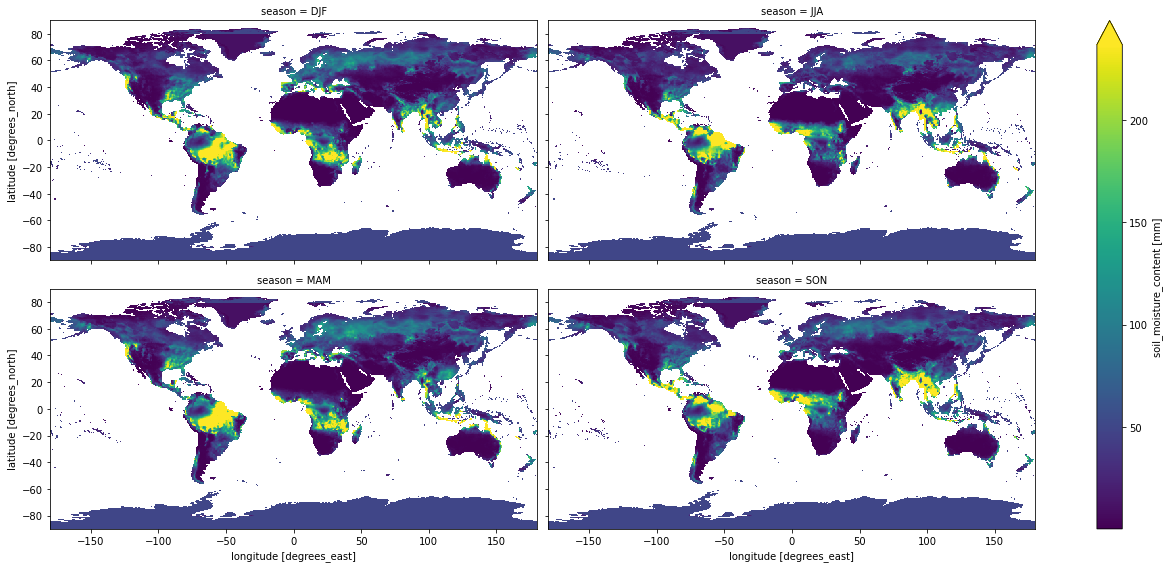

In [11]:
soil_clim.plot(col='season', col_wrap=2, robust=True, figsize=(18, 8))